# Part 1: Data Exploration and Preprocessing

In this notebook, you will implement functions to load, preprocess, and visualize physiological data from the Wearable Exam Stress Dataset.

In [120]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import zscore
from pathlib import Path
import os

# Set style for plots
plt.style.use('seaborn-v0_8-whitegrid')
%matplotlib inline

## 1. Data Loading

Implement the `load_data` function to read and organize the physiological data from the dataset.

In [147]:
def load_data(data_dir='data/raw'):
    """Load and organize the physiological data from the dataset.
    
    Parameters
    ----------
    data_dir : str
        Path to the directory containing the dataset files
        
    Returns
    -------
    final_df : pd.DataFrame
        DataFrame containing the organized physiological data with columns:
        ['timestamp', 'heart_rate', 'eda', 'temperature', 'subject_id', 'session']
    """
    # Make path
    raw_data_path = os.path.join(os.getcwd(), data_dir)
    # Define subjects - they are all in folders that start with S
    subjects = [name for name in os.listdir(raw_data_path) 
            if os.path.isdir(os.path.join(raw_data_path, name)) and name.startswith("S")]
    subjects.sort(key=lambda x: int(x[1:])) # this is required so S10 does not come after S1

    # storing the folder/file names in a data structure
    sessions = ["Final", "Midterm 1", "Midterm 2"]
    signals = ["EDA.csv", "HR.csv", "TEMP.csv"]
    signal_map = {"EDA.csv": "eda", "HR.csv": "heart_rate", "TEMP.csv": "temperature"} # convenient way to rename

    combined_data = []  # list to collect all rows

    for subject in subjects:
        for session in sessions:
            session_data = None

            for signal_file in signals:
                file_path = os.path.join(raw_data_path, subject, session, signal_file)

                if not os.path.exists(file_path):
                    print(f"Missing file: {file_path}")
                    continue

                try:
                    with open(file_path, 'r') as f:
                        lines = f.readlines()

                    # Parse start time and sample rate
                    start_time = float(lines[0].strip())
                    sample_rate = float(lines[1].strip())

                    # Parse signal values
                    values = [float(line.strip()) for line in lines[2:]]
                    num_samples = len(values)

                    # Debug
                    print(f"Subject: {subject}, Session: {session}, Signal: {signal_file}, Start time: {start_time}, Sample rate: {sample_rate}, Num values: {len(values)}")

                    # Generate timestamps
                    timestamps = start_time + np.arange(num_samples) / sample_rate

                    # Create DataFrame
                    df = pd.DataFrame({
                        'timestamp': timestamps,
                        signal_map[signal_file]: values
                    })
                    # print("First few values:") # Debug
                    # print(df.head()) # Debug

                    # Merge with previous signals on timestamp - may be a little fraught
                    if session_data is not None:
                        session_data = pd.merge(session_data, df, on='timestamp', how='outer')
                    else:
                        session_data = df

                except Exception as e:
                    print(f"Error processing {file_path}: {e}")
                    continue

            if session_data is not None and not session_data.empty:
                session_data['subject_id'] = subject
                session_data['session'] = session
                combined_data.append(session_data)

    # Combine all subject-session DataFrames
    final_df = pd.concat(combined_data, ignore_index=True)
    final_df.sort_values(by=['subject_id', 'session', 'timestamp'], inplace=True)
    return final_df

In [129]:
test = load_data()
# print(test.head(55))
# first_col = test.head(50).iloc[:, 0]

# Print without scientific notation
# with pd.option_context('display.float_format', '{:.6f}'.format):
    # print(first_col)

Subject: S1, Session: Final, Signal: EDA.csv, Start time: 1544027337.0, Sample rate: 4.0, Num values: 93582
Subject: S1, Session: Final, Signal: HR.csv, Start time: 1544027347.0, Sample rate: 1.0, Num values: 23387
Subject: S1, Session: Final, Signal: TEMP.csv, Start time: 1544027337.0, Sample rate: 4.0, Num values: 93584
Subject: S1, Session: Midterm 1, Signal: EDA.csv, Start time: 1539435366.0, Sample rate: 4.0, Num values: 44712
Subject: S1, Session: Midterm 1, Signal: HR.csv, Start time: 1539435376.0, Sample rate: 1.0, Num values: 11169
Subject: S1, Session: Midterm 1, Signal: TEMP.csv, Start time: 1539435366.0, Sample rate: 4.0, Num values: 44712
Subject: S1, Session: Midterm 2, Signal: EDA.csv, Start time: 1541859555.0, Sample rate: 4.0, Num values: 44544
Subject: S1, Session: Midterm 2, Signal: HR.csv, Start time: 1541859565.0, Sample rate: 1.0, Num values: 11127
Subject: S1, Session: Midterm 2, Signal: TEMP.csv, Start time: 1541859555.0, Sample rate: 4.0, Num values: 44544
Subj

## 2. Data Preprocessing

Implement the `preprocess_data` function to clean and prepare the data for analysis.

In [148]:
def preprocess_data(data, output_dir='data/processed'):
    """Clean and prepare the physiological data for analysis.
    
    Parameters
    ----------
    data : pd.DataFrame
        Raw physiological data
    output_dir : str
        Directory to save processed data files
        
    Returns
    -------
    data_cleaned : pd.DataFrame
        Cleaned and preprocessed data
    """
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Your code here
    # 1. Handle missing values
    num_missing_rows = data.isnull().any(axis=1).sum()
    print(f"Number of rows with at least one missing value: {num_missing_rows}. Total rows: {len(data)}. Percent rows missing: {num_missing_rows/len(data) * 100}.")
    missing_per_column = data.isnull().sum()
    print(missing_per_column)

    # Linear interpolation... but why???
    data = data.sort_values(['subject_id', 'session', 'timestamp'])

    # function in a function :)
    def interpolate_group(group):
        # Convert timestamp to datetime (if it's not already)
        group['timestamp'] = pd.to_datetime(group['timestamp'], unit='s', errors='coerce')

        # Set timestamp as index
        group = group.set_index('timestamp')

        # Because python goes insane otherwise
        group = group.infer_objects()  

        # Select numeric columns
        numeric_columns = group.select_dtypes(include=['number']).columns
        group[numeric_columns] = group[numeric_columns].interpolate(method='time')

        # Reset index so timestamp is a column again
        return group.reset_index()

    # this throws a warning I can't get rid of... even when I do what I says to silence the warning and tried so hard with dtypes!
    interpolated_data = data.groupby(['subject_id', 'session'], group_keys=False).apply(interpolate_group, include_groups=True)

    num_missing_rows = interpolated_data.isnull().any(axis=1).sum()
    print(f"Number of rows with at least one missing value: {num_missing_rows}. Total rows: {len(interpolated_data)}. Percent rows missing: {num_missing_rows/len(interpolated_data) * 100}.")
    missing_per_column = interpolated_data.isnull().sum()
    print(missing_per_column)

    # now just remove rows with NAs
    data = interpolated_data.dropna(subset=['heart_rate', 'eda', 'temperature']).reset_index(drop=True)
    print(data.shape)

    # also interpolate for irregular intervals - by inspection we know that there are some rows that have a 0.75s interval (instead of 0.25s)

    # Make sure data is sorted and indexed
    data = data.sort_values(['subject_id', 'session', 'timestamp']).reset_index(drop=True)

    data['time_diff'] = data.groupby(['subject_id', 'session'])['timestamp'].diff()

    # Identify rows where time_diff == 750 milliseconds
    mask = data['time_diff'] == pd.Timedelta(milliseconds=750)
    target_indices = data[mask].index

    # List to collect new interpolated rows
    interpolated_rows = []

    # Columns to interpolate
    cols_to_interp = ['temperature', 'heart_rate', 'eda']

    # Loop through each 0.75s gap and interpolate
    for idx in target_indices:
        row_later = data.loc[idx]
        row_earlier = data.loc[idx - 1]

        for step in [0.25, 0.5]:
            new_time = row_earlier['timestamp'] + pd.Timedelta(seconds=step)
            new_row = {
                'subject_id': row_earlier['subject_id'],
                'session': row_earlier['session'],
                'timestamp': new_time,
            }

            for col in cols_to_interp:
                val_early = row_earlier[col]
                val_late = row_later[col]
                interpolated_val = val_early + (val_late - val_early) * (step / 0.75)
                new_row[col] = interpolated_val

            interpolated_rows.append(new_row)

    # Create DataFrame from interpolated rows
    interpolated_df = pd.DataFrame(interpolated_rows)

    # Combine with original data
    data_with_interpolated = pd.concat([data, interpolated_df], ignore_index=True)

    # Sort final result
    data_with_interpolated = data_with_interpolated.sort_values(['subject_id', 'session', 'timestamp']).reset_index(drop=True)

    missing_per_column = data_with_interpolated.isnull().sum()
    print(missing_per_column)

    data_with_interpolated = data_with_interpolated.drop(columns=['time_diff'], errors='ignore')

    # 2. Resample to regular intervals

    # not sure what I want to do here since I actually made everything on the 0.25s and filled in missing data above...
    # kind of seems like a waste to change the timescale to something else, though it would be trivial to resample to any factor of 0.25s
    # I'm going to skip this step...
    
    # 3. Remove outliers (z-score > 3)
    # I'm assuming this is also removing < -3

    # Use scipy.stats
    z_scores = data_with_interpolated[['eda', 'heart_rate', 'temperature']].apply(zscore)

    # Mask to select for certain entries
    mask = (z_scores.abs() <= 3).all(axis=1)

    # Filter the dataframe to keep only non-outlier rows
    data_cleaned = data_with_interpolated[mask].reset_index(drop=True)
    
    # 4. Save processed data to CSV files
    for subject in data_cleaned['subject_id'].unique():
        # Filter data for the current subject
        subject_data = data_cleaned[data_cleaned['subject_id'] == subject]
    
        # Specify the file path by combining the output_dir with the subject's file name
        file_path = os.path.join(output_dir, f"{subject}.csv")
    
        # Save the data for the current subject to the specified directory
        subject_data.to_csv(file_path, index=False)

    return data_cleaned

In [136]:
print(test.head(50))
new = preprocess_data(test)
print(new.head(50))

       timestamp       eda  heart_rate  temperature subject_id session
0   1.544027e+09  0.000000         NaN        21.89         S1   Final
1   1.544027e+09  0.005125         NaN        21.89         S1   Final
2   1.544027e+09  0.020501         NaN        21.89         S1   Final
3   1.544027e+09  0.021783         NaN        21.89         S1   Final
4   1.544027e+09  0.023064         NaN        21.89         S1   Final
5   1.544027e+09  0.024345         NaN        21.89         S1   Final
6   1.544027e+09  0.023064         NaN        21.89         S1   Final
7   1.544027e+09  0.021783         NaN        21.89         S1   Final
8   1.544027e+09  0.023064         NaN        21.91         S1   Final
9   1.544027e+09  0.024345         NaN        21.91         S1   Final
10  1.544027e+09  0.024345         NaN        21.91         S1   Final
11  1.544027e+09  0.023064         NaN        21.91         S1   Final
12  1.544027e+09  0.023064         NaN        21.91         S1   Final
13  1.

C:\Users\kevxs\AppData\Local\Temp\ipykernel_2944\3164915695.py:48: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  interpolated_data = data.groupby(['subject_id', 'session'], group_keys=False).apply(interpolate_group, include_groups=True)


Number of rows with at least one missing value: 1200. Total rows: 1773145. Percent rows missing: 0.06767636036533956.
timestamp         0
eda               0
heart_rate     1200
temperature       0
subject_id        0
session           0
dtype: int64
(1771945, 6)
timestamp       0
eda             0
heart_rate      0
temperature     0
subject_id      0
session         0
time_diff      36
dtype: int64
                 timestamp       eda  heart_rate  temperature subject_id  \
0  2018-12-05 16:29:07.000  0.024345  116.000000        21.91         S1   
1  2018-12-05 16:29:07.250  0.023064  107.625004        21.91         S1   
2  2018-12-05 16:29:07.500  0.024345   99.250000        21.91         S1   
3  2018-12-05 16:29:07.750  0.023064   90.874996        21.91         S1   
4  2018-12-05 16:29:08.000  0.023064   82.500000        21.93         S1   
5  2018-12-05 16:29:08.250  0.023064   85.957498        21.93         S1   
6  2018-12-05 16:29:08.500  0.024345   89.415000        21.93    

In [118]:
def time_diff(data):

    print(data.columns)
    
    # Sort by subject, session, and timestamp
    data = data.sort_values(['subject_id', 'session', 'timestamp'])

    # Compute time differences per subject and session
    data['time_diff'] = data.groupby(['subject_id', 'session'])['timestamp'].diff()

    # Drop first row of each session (has NaN time_diff)
    time_diff_stats = data.dropna(subset=['time_diff']).groupby(['subject_id', 'session'])['time_diff'].agg(['min', 'max', 'nunique'])

    # Filter sessions with more than 1 unique time_diff (i.e., uneven spacing)
    uneven_sessions = time_diff_stats[time_diff_stats['nunique'] > 1]

    # Display sessions with uneven spacing
    print("Sessions with uneven time intervals:")
    print(uneven_sessions)

    # Drop NaNs from the first row in each group
    time_diff_counts = (
    data.dropna(subset=['time_diff'])
         .groupby(['subject_id', 'session'])['time_diff']
         .value_counts()
         .rename('count')
         .reset_index()
    )
    
    # Display results
    print(time_diff_counts)
    pass

# sort again to be sure since we will look at preceding rows
data = data.sort_values(['subject_id', 'session', 'timestamp']).reset_index(drop=True)

# Identify rows where time_diff == 750 milliseconds
mask = data['time_diff'] == pd.Timedelta(milliseconds=750)
target_indices = data[mask].index

# Get the rows with 750ms and their above rows
rows_to_show = pd.concat([data.loc[target_indices], data.loc[target_indices - 1]])

cols_of_interest = ['subject_id', 'session', 'timestamp', 'temperature', 'heart_rate', 'eda']  
cols_available = [col for col in cols_of_interest if col in data.columns]

# Print selected columns
print(rows_to_show[cols_available])

time_diff(test)
time_diff(new)

Empty DataFrame
Columns: [subject_id, session, timestamp, temperature, heart_rate, eda]
Index: []
Index(['timestamp', 'eda', 'heart_rate', 'temperature', 'subject_id',
       'session'],
      dtype='object')
Sessions with uneven time intervals:
                       min   max  nunique
subject_id session                       
S10        Midterm 1  0.25  0.75        2
S6         Final      0.25  0.75        2
           Midterm 1  0.25  0.75        2
   subject_id    session  time_diff   count
0          S1      Final       0.25   93584
1          S1  Midterm 1       0.25   44712
2          S1  Midterm 2       0.25   44544
3         S10      Final       0.25   92292
4         S10  Midterm 1       0.25   46745
5         S10  Midterm 1       0.75       1
6         S10  Midterm 2       0.25   51967
7          S2      Final       0.25  101345
8          S2  Midterm 1       0.25   47936
9          S2  Midterm 2       0.25   55536
10         S3      Final       0.25  103287
11         S3  M

## 3. Visualization

Implement the `plot_physiological_signals` function to create visualizations of the physiological data.

In [149]:
def plot_physiological_signals(data, subject_id, session, output_dir='plots'):
    """Create plots of physiological signals for a given subject and session.

    Parameters
    ----------
    data : pd.DataFrame
        Preprocessed physiological data
    subject_id : str
        Subject identifier (e.g., 'S1')
    session : str
        Session identifier (e.g., 'Midterm 1')
    output_dir : str
        Directory to save plot files

    Returns
    -------
    fig : matplotlib.figure.Figure
        Figure object containing the plots, or None if data is missing
    """
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Filter the data for the given subject and session
    subset = data[(data['subject_id'] == subject_id) & (data['session'] == session)]
    if subset.empty:
        print(f"No data found for subject {subject_id}, session {session}.")
        return None

    # Set up the subplots
    fig, axs = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

    # Plot Temperature
    axs[0].plot(subset['timestamp'], subset['temperature'], color='orange')
    axs[0].set_ylabel('Temperature (°C)')
    axs[0].set_title(f'{subject_id}, {session} - Temperature')

    # Plot Heart Rate
    axs[1].plot(subset['timestamp'], subset['heart_rate'], color='red')
    axs[1].set_ylabel('Heart Rate (bpm)')
    axs[1].set_title(f'{subject_id}, {session} - Heart Rate')

    # Plot EDA
    axs[2].plot(subset['timestamp'], subset['eda'], color='blue')
    axs[2].set_ylabel('EDA (µS)')
    axs[2].set_xlabel('Timestamp')
    axs[2].set_title(f'{subject_id}, {session} - Electrodermal Activity (EDA)')

    # Adjust layout
    fig.tight_layout()

    # Save the figure
    filename = f"{subject_id}_{session.replace(' ', '_')}.png"
    filepath = os.path.join(output_dir, filename)
    fig.savefig(filepath)

    return fig

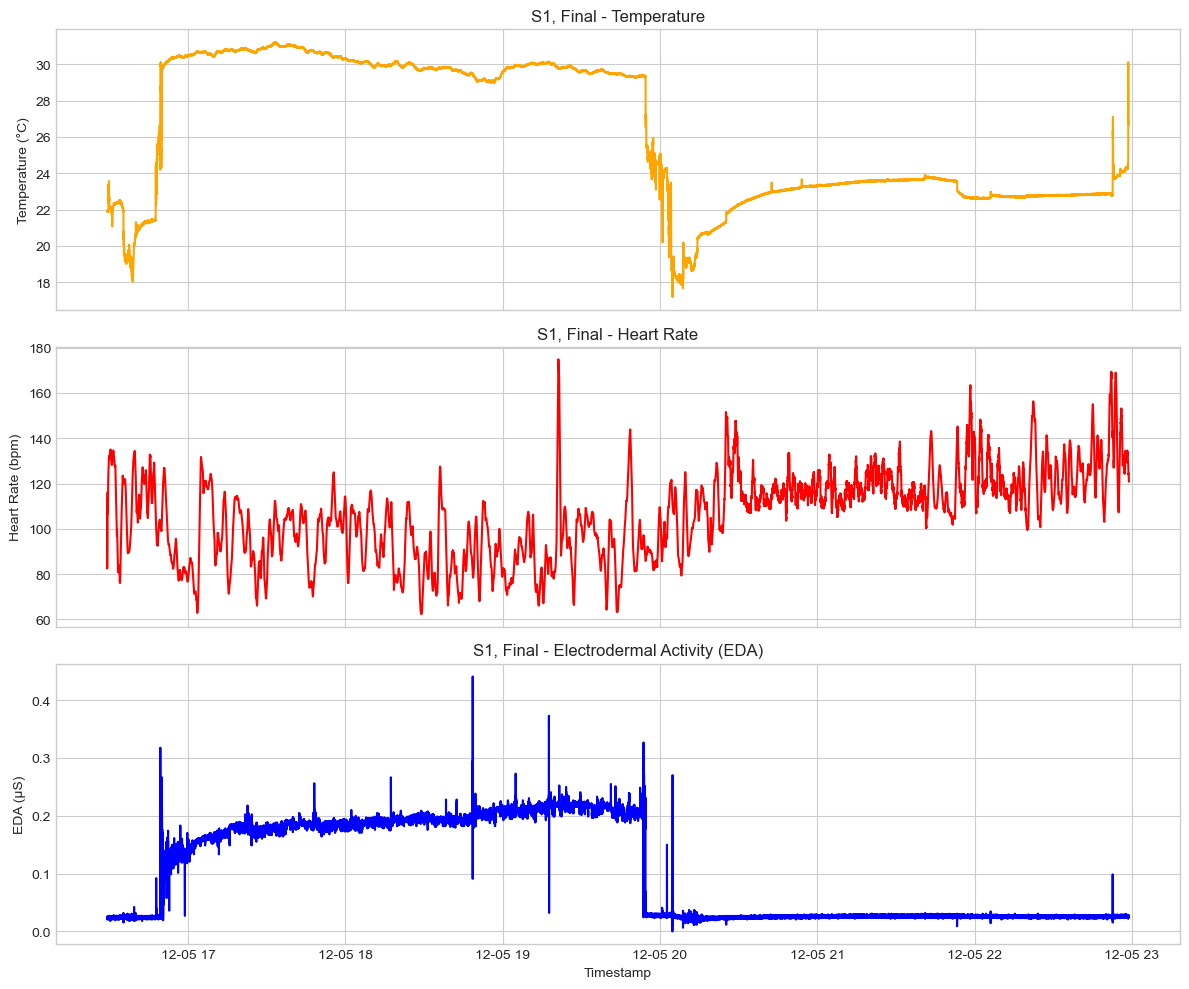

In [152]:
fig = plot_physiological_signals(new, 'S1', 'Final')
plt.show()